# HYCOM mixed layer depth: Spatial trend

In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Define functions

In [2]:
def get_trend(data):
    return np.polyfit(t, data, 1)[0]

### Load datasets

In [3]:
# 0.03 kg/m^3 density contrast
ds = xr.open_dataset('/home/jet/data/opp/converted/ancillary/mld/mld_hycom_030.nc')

# 0.125 kg/m^3 density contrast
#ds = xr.open_dataset('/home/jet/data/opp/converted/ancillary/mld/mld_hycom_125.nc')

In [4]:
# Extract grid cell area from NPP dataset and save in common dataset
ds_npp = xr.open_dataset('/home/jet/data/opp/converted/cbpm/cbpm.nc',decode_times=True)
ds['area'] = ds_npp.area

In [5]:
ds

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 2160, time: 236)
Coordinates:
  * lat      (lat) float64 -89.92 -89.75 -89.58 -89.42 -89.25 -89.08 -88.92 ...
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 -179.2 -179.1 -178.9 ...
  * time     (time) datetime64[ns] 1997-09-15 1997-10-15 1997-11-15 ...
Data variables:
    mld      (time, lat, lon) float32 ...
    area     (lat, lon) float64 ...

In [6]:
print str(ds.time.values[0])[:10]
print str(ds.time.values[-1])[:10]

1997-09-15
2017-04-15


### Set temporal and spatial range

In [7]:
tstart = '1998-01-15'
tend = '2016-12-15'

south = 5
north = 27
west = 50
east = 80

### Subset datasets

In [8]:
mld = ds.mld.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

### Calculate anomalies

In [9]:
mld_anom = mld - mld.mean('time')

### Calculate seasonal anomalies

In [10]:
mld_sanom = mld_anom.groupby('time.month') - mld_anom.groupby('time.month').mean('time')

### Calculate linear trend and its significance

In [11]:
t = mld.time.astype(int)/1e9/3600/24/365.25
mld_trend = np.apply_along_axis(get_trend, 2, mld_sanom.transpose('lat','lon','time'))

### Map linear trend

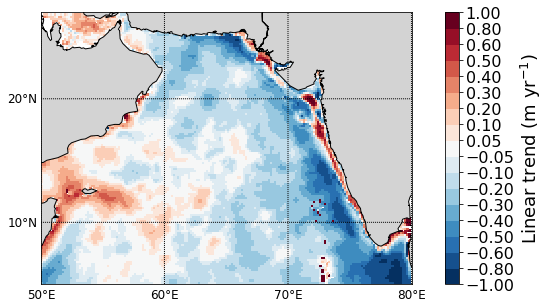

In [18]:
fig = plt.figure(figsize=(12,5))

m = Basemap(projection='cyl',llcrnrlat=south, urcrnrlat=north, llcrnrlon=west, urcrnrlon=east, resolution = 'l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-60,100,10),labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1],fontsize=12)
p = m.pcolormesh(mld.lon, mld.lat, np.ma.masked_invalid(mld_trend), 
                 cmap='RdBu_r', vmin=-1, vmax=1,
                 norm=colors.BoundaryNorm(boundaries=np.array([-1.0,-0.8,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,
                                                               0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]), ncolors=256))
cb = fig.colorbar(p, ticks=np.array([-1.0,-0.8,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,
                                     0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]))
cb.ax.tick_params(labelsize=16)
cb.set_label(r'Linear trend (m yr$^{-1}$)', fontsize=18)
plt.show()